In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
data_dir = "/content/drive/My Drive/chest_xray"
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"
test_dir = f"{data_dir}/test"

In [37]:
import os
print(os.listdir(train_dir))

['NORMAL', 'PNEUMONIA']


In [19]:
# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=32, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(150,150), batch_size=32, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=32, class_mode='binary', shuffle=False)

Found 20 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


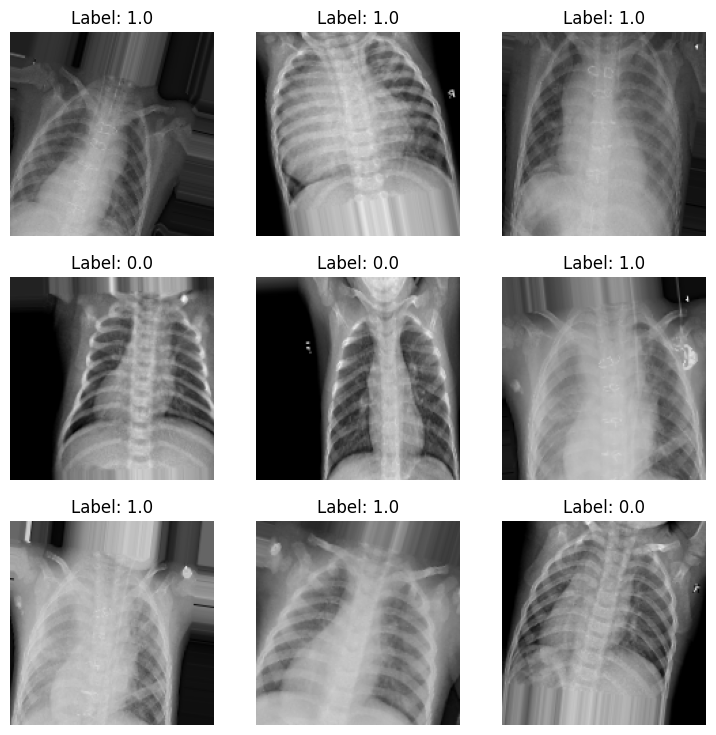

In [21]:
# Visualizing Sample Images
def plot_images(generator):
    images, labels = next(generator)
    fig, axes = plt.subplots(3, 3, figsize=(9,9))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
    plt.show()

plot_images(train_generator)

In [22]:
# CNN Model Definition
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Training the Model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.6000 - loss: 0.6849 - val_accuracy: 0.5000 - val_loss: 1.0351
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5500 - loss: 0.8081 - val_accuracy: 0.5000 - val_loss: 0.9595
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.9905 - val_accuracy: 0.5000 - val_loss: 0.6876
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5500 - loss: 0.7489 - val_accuracy: 0.5000 - val_loss: 0.7054
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4500 - loss: 0.7301 - val_accuracy: 0.5000 - val_loss: 0.6974
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4000 - loss: 0.7030 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6000 - loss: 0.6844 - val_accuracy: 0.5000 - val_loss: 0.6886
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.6756 - val_accuracy: 0.5000 - val_loss: 0.6888
Epoch 9/10
1/1

In [29]:
from sklearn.metrics import accuracy_score
# Compute Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 75.00%


In [24]:
# Model Evaluation
y_pred = (model.predict(test_generator) > 0.5).astype(int)
y_true = test_generator.classes
print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.50      0.67        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20



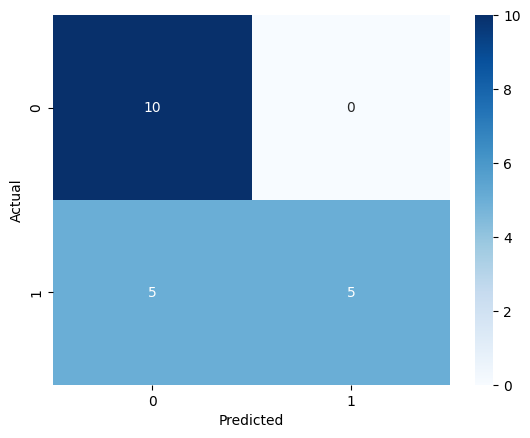

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [39]:
# Pneumonia Prediction Function
def predict_pneumonia(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return "Pneumonia Detected" if prediction > 0.5 else "Normal"

In [46]:
import gdown

# Replace with your file ID
file_id = "1_3ykNL3gs6loinWkXaLkanF-GMVo4UTs"

# Save path (you can change the filename if needed)
image_path = f"/content/{file_id}.jpg"

# Download the image
gdown.download(id=file_id, output=image_path, quiet=False)

# Now you can use 'image_path' to access your downloaded image

Downloading...
From: https://drive.google.com/uc?id=1_3ykNL3gs6loinWkXaLkanF-GMVo4UTs
To: /content/1_3ykNL3gs6loinWkXaLkanF-GMVo4UTs.jpg
100%|██████████| 89.3k/89.3k [00:00<00:00, 3.69MB/s]


'/content/1_3ykNL3gs6loinWkXaLkanF-GMVo4UTs.jpg'

In [47]:
predict_pneumonia(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


'Normal'